# SDF Sampler (3D)

[This in still under development]

In [1]:
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import imageio
import tqdm
from IPython.display import Video

from sdf_sampler.sampler import SDF_3DSampler
from sdf_sampler.utils import sample_2D_grid, plot_sdf, plot_scatter, plot_scatter_redblue
from sdf_sampler.utils import plot_sdf_values, volume_rendering

from sdf.mesh import sample_slice

## Create a sampler and use it to generate a random sdf

In [2]:
sampler = SDF_3DSampler(N=6)

primitives not found, so looking for default ones
operations not found, so looking for default ones
transform not found, so looking for default ones


In [3]:
[p['name'] for p in sampler.primitives.values()]

['plane', 'sphere', 'box', 'wireframe box', 'cylinder', 'torus']

In [4]:
[o['name'] for o in sampler.operations.values()]

['union',
 'intersection',
 'blend',
 'negate_union',
 'negate_intersection',
 'difference']

In [5]:
sample = sampler()

## Visualize it

We can use underlying methods from sdf library to explore a slice of it.

Warning: if the sampler failed to generate a good sample (I believe by a concatenation of bad scaling factors) then the sdf will be moved far away from origin and its values will be large. Until solving the issue we can sort this issue taking another sample.

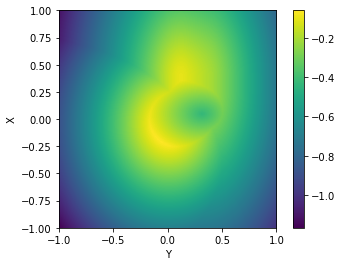

In [6]:
# forcing boundaries helps to avoid problems with weird samples
bounds = ((-1,-1,-1),(1,1,1))
sample.sdf().show_slice(z=0, w=512, h=512, bounds=bounds)

In [7]:
a, extent, axes = sample_slice(sample.sdf(), w=512, h=512, z=0.0, bounds=bounds)

In [8]:
a.min(), a.max()

(-1.1674798069896983, -0.05940156075835126)

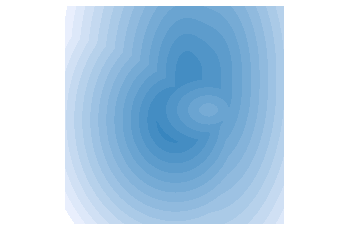

In [9]:
plot_sdf_values(a, w=512, h=512)

We can use the underlying library to export the mesh using marching cubes

In [10]:
outdir = 'renders'
os.makedirs(outdir, exist_ok=True)

In [11]:
sample.sdf().save(os.path.join(outdir, 'sample3D.stl'), samples=2**25, bounds=bounds)

min -1, -1, -1
max 1, 1, 1
step 0.00620079, 0.00620079, 0.00620079
36926037 samples in 1331 batches with 16 workers
  100% (1331 of 1331) [##############################] 0:00:05 0:00:00    
1294 skipped, 37 empty, 0 nonempty
0 triangles in 5.30897 seconds


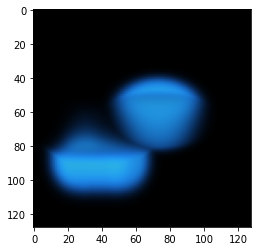

In [12]:
image = volume_rendering(sample.sdf())
plt.imshow(image)
plt.show()

In [13]:
vid = 1
video_name = os.path.join(outdir, f'volume_rendering_{vid:02}.mp4') 
frames = []
thetas = np.linspace(0, np.pi*2, 24)
bar = tqdm.tqdm(thetas)
for i, theta in enumerate(bar):
    bar.set_description(f'volume rendering {i} with theta={theta:.2f}')
    image = volume_rendering(sample.sdf(), theta=theta)
    frames.append(image)
frames = (np.array(frames + frames[::-1])*255).astype(np.uint8)
imageio.mimwrite(video_name, np.array(frames), fps=10, macro_block_size=8, quality=8)

volume rendering 23 with theta=6.28: 100%|█████████████████████████████████████████████| 24/24 [01:01<00:00,  2.56s/it]


In [14]:
Video(video_name)

In [15]:
video_name

'renders\\volume_rendering_01.mp4'

In [16]:
def create_transfer_function(rgb_gaussians_loc=(0.1, 0.0, -0.1)):
    def transfer_function(x):
        rc, gc, bc = rgb_gaussians_loc
        r = 1.0*np.exp( -(x - rc)**2/0.01 )   +  0.1*np.exp( -(x - gc)**2/0.01 ) +  0.10*np.exp( -(x - bc)**2/0.01 )
        g = 0.1*np.exp( -(x - rc)**2/0.01 )   +  1.0*np.exp( -(x - gc)**2/0.02 ) +  0.10*np.exp( -(x - bc)**2/0.01 )
        b = 0.1*np.exp( -(x - rc)**2/0.01 )   +  0.1*np.exp( -(x - gc)**2/0.01 ) +  1.00*np.exp( -(x - bc)**2/0.01 )
        a = 0.005*np.exp( -(x - rc)**2/0.01 ) +  0.6*np.exp( -(x - gc)**2/0.01 ) +  0.01*np.exp( -(x - bc)**2/0.01 )
        return r,g,b,a
    return transfer_function

In [17]:
vid = 2
video_name = os.path.join(outdir, f'volume_rendering_{vid:02}.mp4') 
frames = []
thetas = np.linspace(0, np.pi*2, 24)
bar = tqdm.tqdm(thetas)
rgb_gaussians_loc = np.array([0.0, 0.0, 0.0])
dx = np.linspace(0, 1, len(thetas))
for i, theta in enumerate(bar):
    bar.set_description(f'volume rendering {i} with theta={theta:.2f}')
    rgb_gaussians_loc[0] = dx[i]
    rgb_gaussians_loc[2] = -dx[i]
    image = volume_rendering(sample.sdf(), theta=theta, transfer_function=create_transfer_function(rgb_gaussians_loc))
    frames.append(image)
frames = (np.array(frames + frames[::-1])*255).astype(np.uint8)
imageio.mimwrite(video_name, np.array(frames), fps=10, macro_block_size=8, quality=8)

volume rendering 23 with theta=6.28: 100%|█████████████████████████████████████████████| 24/24 [00:57<00:00,  2.41s/it]


In [18]:
Video(video_name)

In [19]:
def create_transfer_function(rgb_gaussians_loc=(0.1, 0.0, -0.1), alpha_green=1.0):
    def transfer_function(x):
        rc, gc, bc = rgb_gaussians_loc
        ag = alpha_green
        r = 1.0*np.exp( -(x - rc)**2/0.01 )   +  0.1*np.exp( -(x - gc)**2/0.01 ) +  0.10*np.exp( -(x - bc)**2/0.01 )
        g = 0.1*np.exp( -(x - rc)**2/0.01 )   +  1.0*np.exp( -(x - gc)**2/0.02 ) +  0.10*np.exp( -(x - bc)**2/0.01 )
        b = 0.1*np.exp( -(x - rc)**2/0.01 )   +  0.1*np.exp( -(x - gc)**2/0.01 ) +  1.00*np.exp( -(x - bc)**2/0.01 )
        a = 0.05*np.exp( -(x - rc)**2/0.01 )  +   ag*np.exp( -(x - gc)**2/0.01 ) + 0.01*np.exp( -(x - bc)**2/0.01 )
        return r,g,b,a
    return transfer_function

In [20]:
vid = 3
video_name = os.path.join(outdir, f'volume_rendering_{vid:02}.mp4') 
frames = []
thetas = np.linspace(0, np.pi*2, 48)
bar = tqdm.tqdm(thetas)
rgb_gaussians_loc = np.array([0.0, 0.0, 0.0])
dx = np.linspace(0, 1, len(thetas//2))
for i, theta in enumerate(bar):
    bar.set_description(f'volume rendering {i} with theta={theta:.2f}')
    rgb_gaussians_loc[0] = dx[i % len(dx)]
    rgb_gaussians_loc[2] = -dx[i % len(dx)]
    alpha_green = dx[-((i % len(dx))+1)]
    image = volume_rendering(sample.sdf(), theta=theta,
                             transfer_function=create_transfer_function(rgb_gaussians_loc, alpha_green))
    frames.append(image)
frames = (np.array(frames + frames[::-1])*255).astype(np.uint8)
imageio.mimwrite(video_name, np.array(frames), fps=10, macro_block_size=8, quality=8)

volume rendering 47 with theta=6.28: 100%|█████████████████████████████████████████████| 48/48 [02:00<00:00,  2.52s/it]


In [21]:
Video(video_name)

Increase volume grid resolution to 256 for volume rendering

In [22]:
vid = 4
video_name = os.path.join(outdir, f'volume_rendering_{vid:02}.mp4') 
frames = []
thetas = np.linspace(0, np.pi*2, 48)
bar = tqdm.tqdm(thetas)
rgb_gaussians_loc = np.array([0.0, 0.0, 0.0])
dx = np.linspace(0, 1, len(thetas//2))
for i, theta in enumerate(bar):
    rgb_gaussians_loc[0] = dx[i % len(dx)]
    rgb_gaussians_loc[2] = -dx[i % len(dx)]*.2
    alpha_green = dx[-((i % len(dx))+1)]
    locs = ', '.join([f'{g:.03f}' for g in rgb_gaussians_loc])
    bar.set_description(f'volume rendering {i} with theta={theta:.2f} alpha_green={alpha_green:.02f} locs=({locs})')
    image = volume_rendering(sample.sdf(), N=256, theta=theta,
                             transfer_function=create_transfer_function(rgb_gaussians_loc, alpha_green))
    frames.append(image)
frames = (np.array(frames + frames[::-1])*255).astype(np.uint8)
imageio.mimwrite(video_name, np.array(frames), fps=10, macro_block_size=8, quality=8)

volume rendering 47 with theta=6.28 alpha_green=0.00 locs=(1.000, 0.000, -0.200): 100%|█| 48/48 [15:19<00:00, 19.16s/it


In [23]:
Video(video_name)

## Show how the SDF was created

In [24]:
print(sample.root)


   _∪(c,~∪(∪(wb,-(wb,~∩(c,t))),t))_11_______________________________________________________________________________
  /                                                                                                                 \
c_2                                                    _________________________________________________~∪(∪(wb,-(wb,~∩(c,t))),t)_10_
                                                      /                                                                              \
                                         __∪(wb,-(wb,~∩(c,t)))_9____________                                                         t_6
                                        /                                   \
                                      wb_4                          __-(wb,~∩(c,t))_8________
                                                                   /                         \
                                                                 wb_3                    _~

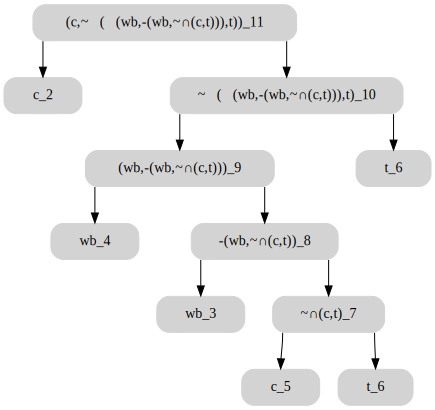

In [25]:
sample.root

Every sample needs to keep track of the sdf used to generate values because they will be used on demand

In [26]:
len(sample.sdfs_list)

12

This allows us to see the pieces that helped to created the final sdf

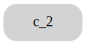

In [27]:
sample.root.left

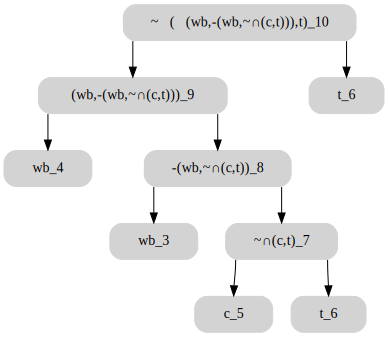

In [28]:
sample.right

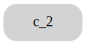

In [29]:
sample.left

### How to use the SDF to extract its values for coordinates?

By default every generated shape tries to be in range (-1, 1) but it doesn't mean we can't explore the whole sdf space

In [30]:
# create a list of coordinates than belongs to a 20x20 grid in range -5 to 5
grid = sample_2D_grid(resolution=20, low=-5, high=5)
# add 2 more dimension
grid = np.hstack((grid, np.zeros_like(grid[:,0:1])))
grid.shape

(400, 3)

In [31]:
# get the sdf values for these coordinates
sdf_values = sample().f(grid)
sdf_values = sdf_values.flatten()

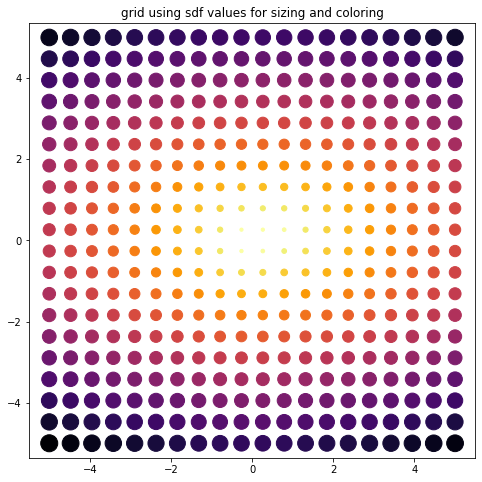

In [32]:
fig = plt.figure(figsize=(8,8))
size = np.abs(sdf_values*50)

plt.scatter(grid[:,0], grid[:,1], s=size, c=sdf_values, cmap='inferno')

# fix axis
plt.axis('equal')
plt.title('grid using sdf values for sizing and coloring')
plt.show()

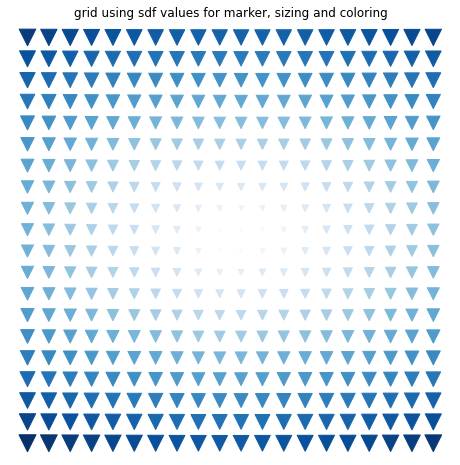

In [33]:
# similar but chainging shape base of sdf value sign

fig = plt.figure(figsize=(8,8))

pos = (sdf_values >= 0)
neg = (sdf_values < 0)

size = np.abs(sdf_values*50)
for marker, cond, cmap in zip(['^','v'], [pos, neg], ['Reds', 'Blues_r']):
    plt.scatter(grid[cond,0], grid[cond,1], s=size[cond], c=sdf_values[cond], cmap=cmap, marker=marker)

# fix axis
plt.axis('equal')
plt.axis('off')
plt.title('grid using sdf values for marker, sizing and coloring')
plt.show()

We can increase the resolution looking closer into range -1 to 1

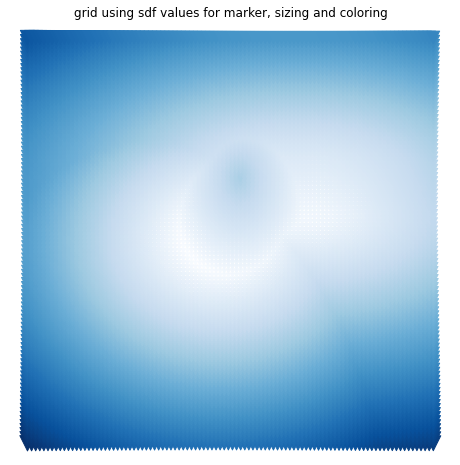

In [34]:
grid = sample_2D_grid(resolution=100, low=-1, high=1)
grid = np.hstack((grid, np.zeros_like(grid[:,0:1])))
sdf_values = sample().f(grid)
sdf_values = sdf_values.flatten()

fig = plt.figure(figsize=(8,8))

pos = (sdf_values >= 0)
neg = (sdf_values < 0)

size = np.abs(sdf_values*200)
for marker, cond, cmap in zip(['^','v'], [pos, neg], ['Reds', 'Blues_r']):
    plt.scatter(grid[cond,0], grid[cond,1], s=size[cond], c=sdf_values[cond], cmap=cmap, marker=marker)

# fix axis
plt.axis('equal')
plt.axis('off')
plt.title('grid using sdf values for marker, sizing and coloring')
plt.show()

Let's use the sampler like a sampler

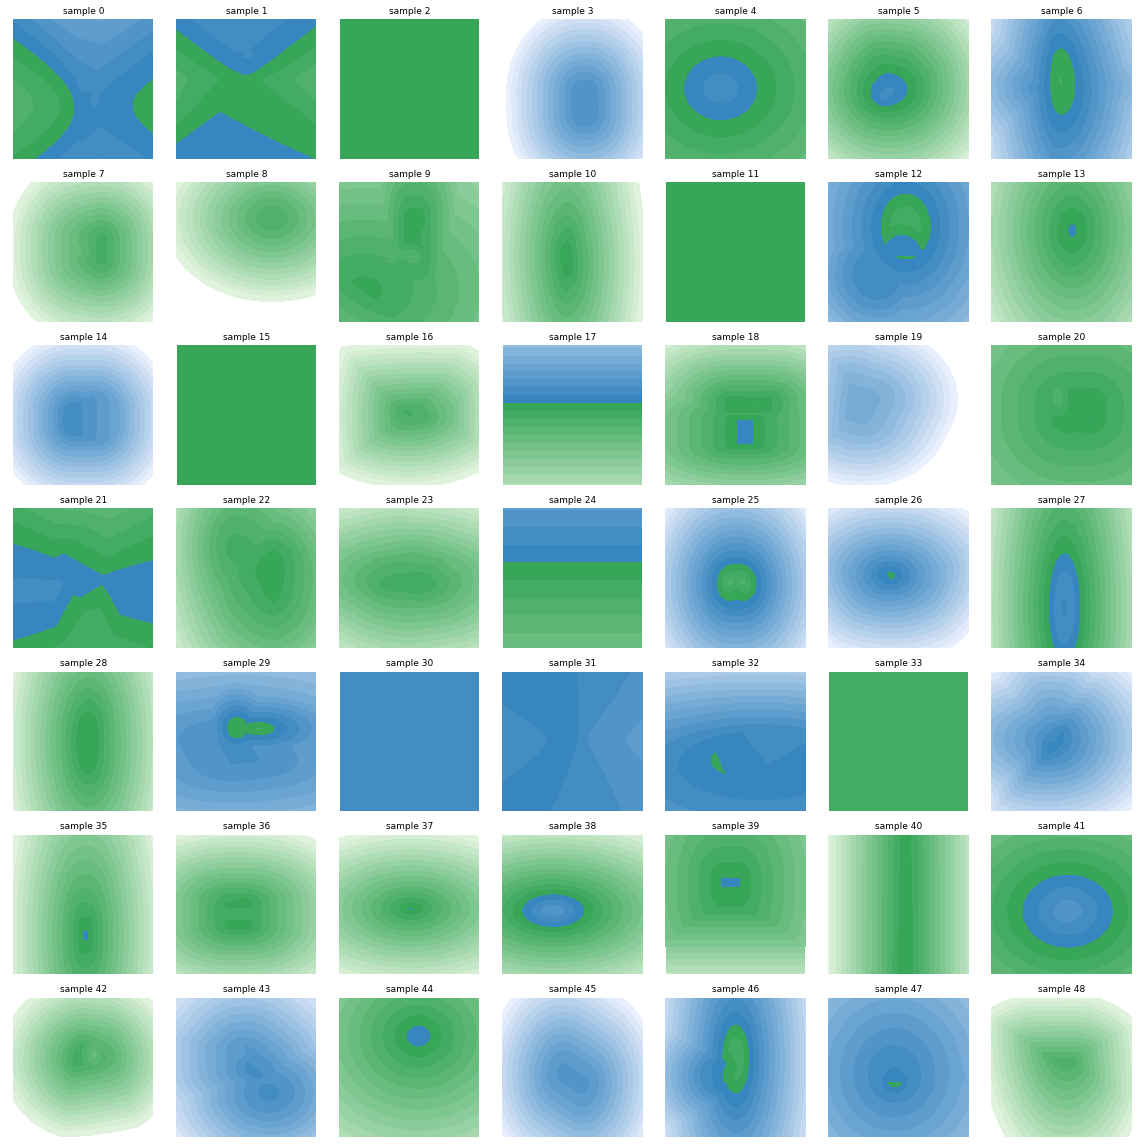

In [35]:
fig, axes = plt.subplots(7,7,figsize=(16,16))
axes = axes.flatten().tolist()
for i, ax in enumerate(axes):
    sample = sampler()
    a, extent, axes = sample_slice(sample.sdf(), w=256, h=256, z=0.0, bounds=((-1,-1,-1), (1,1,1)))
    plot_sdf_values(a, w=256, h=256, ax=ax, title=f'sample {i}')
plt.tight_layout()
plt.show()

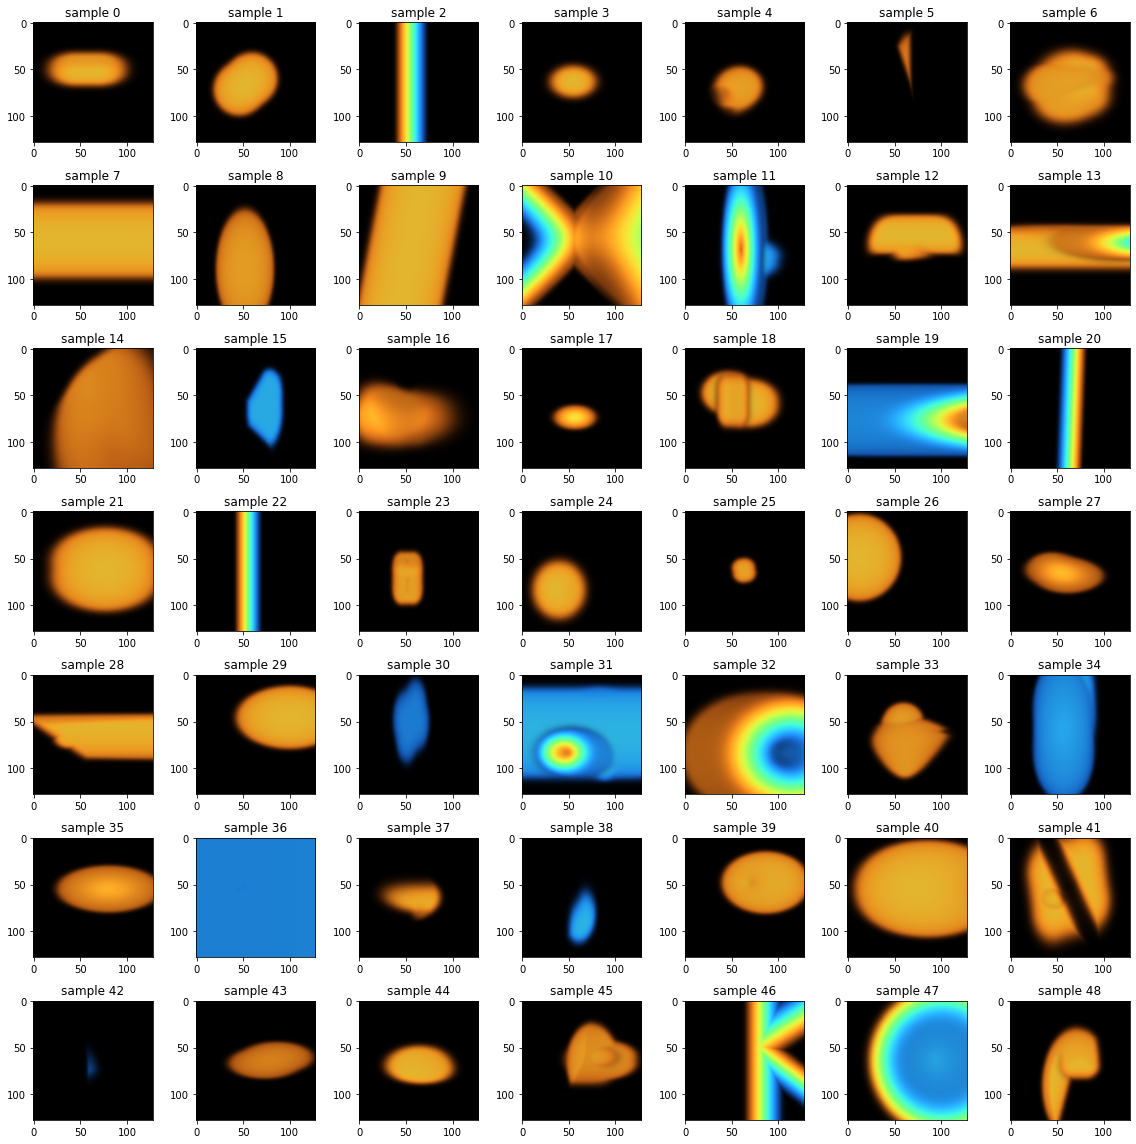

In [36]:
fig, axes = plt.subplots(7,7,figsize=(16,16))
axes = axes.flatten().tolist()
for i, ax in enumerate(axes):
    sample = sampler()
    image = volume_rendering(sample.sdf())
    ax.imshow(image)
    ax.set_title(f'sample {i}')
plt.tight_layout()
plt.show()

Last sample composition

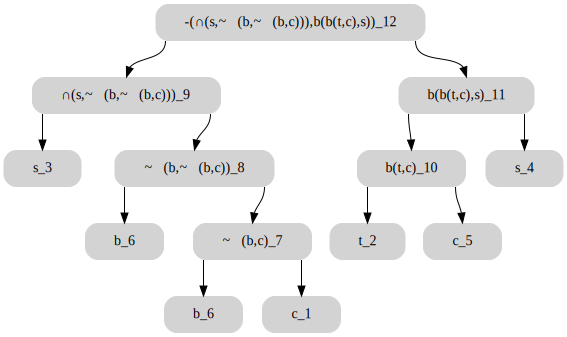

In [37]:
sample.root